In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys
sys.path.append("../src")

In [5]:
from CompoTree import ComponentTree, Radicals, TSVariants, CharLexicon, CTFounds
from gensim.models.keyedvectors import KeyedVectors
import numpy as np
import numpy.linalg as la
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
plt.rcParams["font.family"] = "HanaMinA" 

In [6]:
kv = KeyedVectors.load("../data/fasttext-zh-sw/fasttext-zh-sw.kv")
kv.init_sims()

In [7]:
ctree = ComponentTree.load()
radicals = Radicals.load()
tsvars = TSVariants.load()
lexicon = CharLexicon.load(topn=3000)

In [8]:
[(x, y) for x, y in ctree.mutual_friends("木", "火")
 if x in lexicon.traditional and y in lexicon.traditional]

[WARNING] current implementation only consider two-component characters with target at the first position


[('杜', '灶'), ('柄', '炳'), ('欄', '爛')]

In [9]:
targets = "澄橙燈杆欄爛炒沙汗"
vectors = np.array(
          [5, 4,
           2, 8,
           7, 8,
           2.5, 9,
           1.5, 9,
           8.5, 5.5,
           8.5, 8.5,
           5.5, 1,
           2.5, 1])
vectors = np.reshape(vectors, (9, 2))

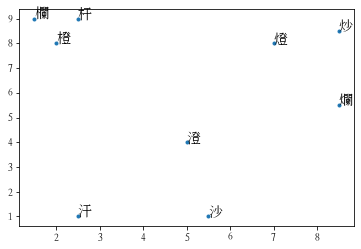

In [10]:
plt.plot(vectors[:,0], vectors[:, 1], '.')
for i, ch in enumerate(targets):
    plt.text(vectors[i, 0], vectors[i, 1], targets[i], fontsize=14)

In [99]:
from itertools import chain
def make_decompo_matrix(chars):
    decompos = {}
    for ch in chars:
        node = ctree.query(ch, use_flag="shortest", max_depth=1)[0]
        if isinstance(node, str):
            continue
        decompos[ch] = node.components()
    compolist = list(chain.from_iterable(decompos.values()))
    compolist = sorted(set(compolist))
    
    decompo_matrix = np.zeros((len(chars), len(compolist)))
    for ch, compos in decompos.items():
        decompo_matrix[
            chars.index(ch), 
            [compolist.index(x) for x in compos]] = 1
    return decompo_matrix, compolist

In [100]:
dcmat, compolist = make_decompo_matrix(targets)
# reorder the column for easier testing
dcmat = dcmat[:,[compolist.index(x) for x in "氵木火登干闌少"]]
compolist = "氵木火登干闌少"

In [101]:
# There is a constraint that since I choose bi-component character, the row-sum must be 2
# therefore there must be a rank-deficit
la.matrix_rank(dcmat)

6

$$
\begin{align}
\phi_{i,j} &= e^{-d(z_i, c_j)/\sigma_j}, \textrm{if $z_i \in \mathcal{H}(c_i)$, else 0}\\
p(c_j|z_i) &= \frac{\phi_{i,j}}{\sum_j \phi_{i,j}} \\
p(z_i|c_j) &= \frac{p(c_j|z_i)p(z_i)}{\sum_{z_i \in \mathcal{H}(c_j)}{p(c_j|z_i)p(z_i)}} \\
v(c_j) &= \sum_{z_i\in\mathcal{H}(c_j)} p(z_i|c_j) v(z_i)
\end{align}
$$

$\phi_{i,j}$: score between character $i$ and component $j$  
$d(z_i, c_j)$: the distance metric between character $i$, $z_i$ and component $j$, $c_j$  
$\mathcal{H}(c_j)$: the characters containing component $c_j$  
$v(c_j)$: the embedding vector of $c_j$

In [103]:
from scipy.spatial.distance import euclidean

## initialize

In [ ]:
np.set_printoptions(precision=4)

In [155]:
phi = dcmat.copy()
compo_vectors = np.zeros((len(compolist), vectors.shape[1]))

## Playground

In [166]:
compo_vectors

array([[4.3333, 2.    ],
       [2.    , 8.6667],
       [8.    , 7.3333],
       [4.6667, 6.6667],
       [2.5   , 5.    ],
       [5.    , 7.25  ],
       [7.    , 4.75  ]])

In [173]:
dist = np.zeros_like(phi)
for i in range(vectors.shape[0]):
    for j in range(compo_vectors.shape[0]):
        dist[i,j] = euclidean(vectors[i, :], compo_vectors[j, :])        
sigmas = np.std(dist, axis=0)
phi = np.exp(-dist/sigmas)
phi = phi * dcmat

In [174]:
phi

array([[0.4165, 0.    , 0.    , 0.1017, 0.    , 0.    , 0.    ],
       [0.    , 0.8031, 0.    , 0.0792, 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.6199, 0.1017, 0.    , 0.    , 0.    ],
       [0.    , 0.8206, 0.    , 0.    , 0.0467, 0.    , 0.    ],
       [0.    , 0.8206, 0.    , 0.    , 0.    , 0.0651, 0.    ],
       [0.    , 0.    , 0.4695, 0.    , 0.    , 0.0651, 0.    ],
       [0.    , 0.    , 0.6035, 0.    , 0.    , 0.    , 0.1028],
       [0.5282, 0.    , 0.    , 0.    , 0.    , 0.    , 0.1028],
       [0.42  , 0.    , 0.    , 0.    , 0.0467, 0.    , 0.    ]])

In [175]:
pcz = phi/phi.sum(axis=1, keepdims=True)

In [176]:
pz = np.ones(phi.shape[0]) / phi.shape[0]  # uniform character weight

In [177]:
pcz

array([[0.8037, 0.    , 0.    , 0.1963, 0.    , 0.    , 0.    ],
       [0.    , 0.9102, 0.    , 0.0898, 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.859 , 0.141 , 0.    , 0.    , 0.    ],
       [0.    , 0.9461, 0.    , 0.    , 0.0539, 0.    , 0.    ],
       [0.    , 0.9265, 0.    , 0.    , 0.    , 0.0735, 0.    ],
       [0.    , 0.    , 0.8782, 0.    , 0.    , 0.1218, 0.    ],
       [0.    , 0.    , 0.8544, 0.    , 0.    , 0.    , 0.1456],
       [0.837 , 0.    , 0.    , 0.    , 0.    , 0.    , 0.163 ],
       [0.8998, 0.    , 0.    , 0.    , 0.1002, 0.    , 0.    ]])

In [202]:
pzc = pcz * pz[:, np.newaxis]
# pzc = pzc * dcmat
pzc = pzc / pzc.sum(axis=0)
pzc

array([[0.23  , 0.    , 0.    , 0.4311, 0.    , 0.    , 0.    ],
       [0.    , 0.2786, 0.    , 0.3117, 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.339 , 0.2571, 0.    , 0.    , 0.    ],
       [0.    , 0.3933, 0.    , 0.    , 0.3254, 0.    , 0.    ],
       [0.    , 0.3281, 0.    , 0.    , 0.    , 0.4017, 0.    ],
       [0.    , 0.    , 0.23  , 0.    , 0.    , 0.5983, 0.    ],
       [0.    , 0.    , 0.4311, 0.    , 0.    , 0.    , 0.4157],
       [0.4713, 0.    , 0.    , 0.    , 0.    , 0.    , 0.5843],
       [0.2987, 0.    , 0.    , 0.    , 0.6746, 0.    , 0.    ]])

In [164]:
prev_compo_vectors = compo_vectors.copy()
compo_vectors = pzc.T.dot(vectors)

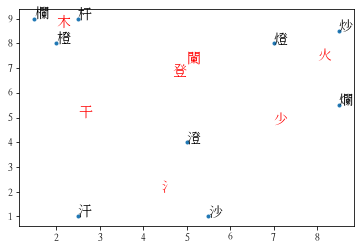

In [165]:
plt.plot(vectors[:,0], vectors[:, 1], '.')
for i, ch in enumerate(targets):
    plt.text(vectors[i, 0], vectors[i, 1], ch, fontsize=14)
for j, compo in enumerate(compolist):
    plt.text(compo_vectors[j, 0], compo_vectors[j, 1], compo, fontsize=14, color="red")

## Iterations

In [145]:
from tqdm.auto import tqdm

In [203]:
# initialize
phi = dcmat.copy()
compo_vectors = np.zeros((len(compolist), vectors.shape[1]))
compo_history = []
delta_list = []

## MLE of component vector
for iter_i in tqdm(range(20)):
    dist = np.zeros_like(phi)
    for i in range(vectors.shape[0]):
        for j in range(compo_vectors.shape[0]):
            dist[i,j] = euclidean(vectors[i, :], compo_vectors[j, :])        
    dist = dist * dcmat
    sigmas = np.std(dist, axis=0)
    phi = np.exp(-dist/sigmas)
    phi = phi * dcmat
    pcz = phi/phi.sum(axis=1, keepdims=True)
    pz = np.ones(phi.shape[0]) / phi.shape[0]  # uniform character weight    
    pzc = pcz * pz[:, np.newaxis]
    pzc = pzc / pzc.sum(axis=0)
    prev_compo_vectors = compo_vectors.copy()
    compo_vectors = pzc.T.dot(vectors)
    diff_vectors = compo_vectors - prev_compo_vectors
    delta = la.norm(diff_vectors, axis=1).sum()
    delta_list.append(delta)
    compo_history.append(compo_vectors)

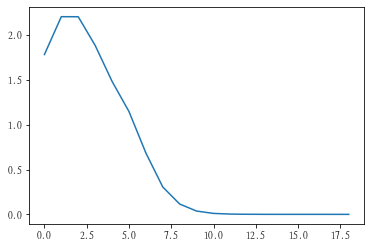

In [208]:
plt.plot(delta_list[1:])

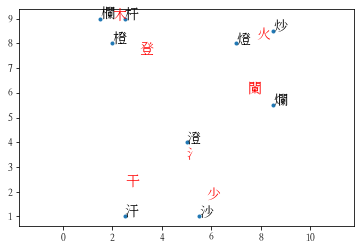

In [205]:
plt.plot(vectors[:,0], vectors[:, 1], '.')
plt.axis("equal")
for i, ch in enumerate(targets):
    plt.text(vectors[i, 0], vectors[i, 1], ch, fontsize=14)
for j, compo in enumerate(compolist):
    plt.text(compo_vectors[j, 0], compo_vectors[j, 1], compo, fontsize=14, color="red")

In [206]:
pzc

array([[0.7753, 0.    , 0.    , 0.1066, 0.    , 0.    , 0.    ],
       [0.    , 0.0591, 0.    , 0.7358, 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.4525, 0.1577, 0.    , 0.    , 0.    ],
       [0.    , 0.4704, 0.    , 0.    , 0.1494, 0.    , 0.    ],
       [0.    , 0.4705, 0.    , 0.    , 0.    , 0.1451, 0.    ],
       [0.    , 0.    , 0.0375, 0.    , 0.    , 0.8549, 0.    ],
       [0.    , 0.    , 0.51  , 0.    , 0.    , 0.    , 0.095 ],
       [0.1378, 0.    , 0.    , 0.    , 0.    , 0.    , 0.905 ],
       [0.0869, 0.    , 0.    , 0.    , 0.8506, 0.    , 0.    ]])

In [207]:
pcz

array([[0.8705, 0.    , 0.    , 0.1295, 0.    , 0.    , 0.    ],
       [0.    , 0.1058, 0.    , 0.8942, 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.8084, 0.1916, 0.    , 0.    , 0.    ],
       [0.    , 0.8415, 0.    , 0.    , 0.1585, 0.    , 0.    ],
       [0.    , 0.8417, 0.    , 0.    , 0.    , 0.1583, 0.    ],
       [0.    , 0.    , 0.067 , 0.    , 0.    , 0.933 , 0.    ],
       [0.    , 0.    , 0.9112, 0.    , 0.    , 0.    , 0.0888],
       [0.1548, 0.    , 0.    , 0.    , 0.    , 0.    , 0.8452],
       [0.0976, 0.    , 0.    , 0.    , 0.9024, 0.    , 0.    ]])

## Visualization

In [213]:
np.stack(compo_history, axis=0).shape

(20, 7, 2)

In [217]:
compo_traces.shape[1]

7

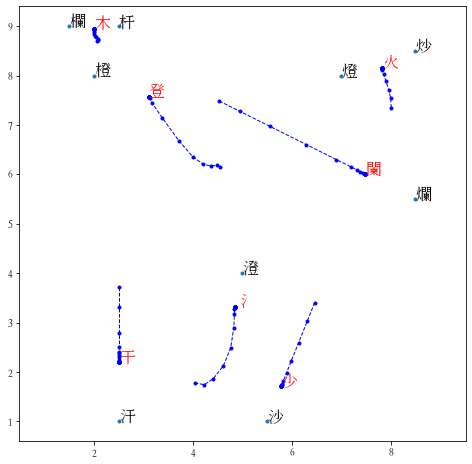

In [225]:
plt.figure(figsize=(8,8))
plt.plot(vectors[:,0], vectors[:, 1], '.')
plt.axis("equal")
compo_traces = np.stack(compo_history, axis=0)
for i, ch in enumerate(targets):
    plt.text(vectors[i, 0], vectors[i, 1], ch, fontsize=16)
for j in range(compo_traces.shape[1]):
    plt.plot(compo_traces[:, j, 0], compo_traces[:, j, 1], color="blue", linestyle='--', marker=".", linewidth=1)
for j, compo in enumerate(compolist):
    plt.text(compo_vectors[j, 0], compo_vectors[j, 1], compo, fontsize=16, color="red")